In [1]:
# Input:
train_path = '/content/train'
val_path = '/content/val/'
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
image_size = (150, 150)
n_output = len(classes)

metrics=['accuracy']
epochs=30
batch_size=500
model_name='recognizer.hdf5'
monitor='val_accuracy'
mode='max'
patience=10
test_score, val_score = 'accuracy', 'val_accuracy'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Copy from drive to colab
# !cp "/content/drive/MyDrive/scene images dataset/val.zip" /content/
# !cp "/content/drive/MyDrive/scene images dataset/train.zip" /content/

In [3]:
!nvidia-smi

Tue Dec 26 02:50:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!unzip /content/val.zip

In [ ]:
!unzip /content/train.zip

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.utils import load_img, img_to_array

# Create functions

In [11]:
# Image generators
def image_generators(train_path, val_path, image_size):
    # Create data generators
    train_imgGen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        shear_range = 0.2,
        fill_mode = 'nearest',
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    val_imgGen = ImageDataGenerator(rescale=1./255)

    # Run the image generators
    train_gen = train_imgGen.flow_from_directory(
        train_path,
        target_size=image_size,
        batch_size=64,
        class_mode='categorical'
    )

    val_gen = val_imgGen.flow_from_directory(
        val_path,
        target_size=image_size,
        batch_size=64,
        class_mode='categorical'
    )

    return train_gen, val_gen

In [12]:
# Build CNN model
def build_architecture(image_size, n_output, metrics=['accuracy']):
    cnn = tf.keras.models.Sequential([
        ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(image_size[0], image_size[1], 3))),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_output, activation='sigmoid')
    ])
    cnn.layers[0].trainable = False

    # Complie model CNN
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

    return cnn

In [19]:
# Fit CNN model
def fit_cnn(
    cnn,
    train_gen,
    val_gen,
    epochs,
    batch_size,
    model_name='recognizer.hdf5',
    monitor='val_accuracy',
    mode='max',
    patience=10
):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    # Learning rate # riset yg bagus gimana
    # learning_rate_callback = LearningRateScheduler(
    #     lambda epoch: 1e-5 * 10**(epoch/2), verbose=0
    # )

    tf.keras.utils.set_random_seed(123)

    # Fit the CNN
    cnn_history = cnn.fit(
          train_gen,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=val_gen,
          callbacks=[es, checkpoint],
          verbose=2
    )

    return cnn, cnn_history

In [27]:
# Plot model history
def plot_history(cnn_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(cnn_history.history[test_score])
    ax[0].plot(cnn_history.history[val_score])
    ax[0].set_title(f'CNN {test_score}')
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(cnn_history.history['loss'])
    ax[1].plot(cnn_history.history['val_loss'])
    ax[1].set_title('CNN loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()


# Run functions

In [15]:
# Image generators
train_gen, val_gen = image_generators(train_path, val_path, image_size)

Found 2402 images belonging to 6 classes.
Found 598 images belonging to 6 classes.


In [16]:
# Build CNN model
cnn = build_architecture(image_size, n_output, metrics=['accuracy'])

234545216/234545216 [==============================] - 2s 0us/step


In [23]:
# Fit CNN model
cnn, cnn_history = fit_cnn(
    cnn,
    train_gen,
    val_gen,
    epochs,
    batch_size,
    model_name,
    monitor,
    mode,
    patience
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 - 38s - loss: 0.9986 - accuracy: 0.7040 - val_loss: 0.4536 - val_accuracy: 0.8528 - 38s/epoch - 987ms/step
Epoch 2/30
38/38 - 22s - loss: 0.4815 - accuracy: 0.8426 - val_loss: 0.3942 - val_accuracy: 0.8746 - 22s/epoch - 589ms/step
Epoch 3/30
38/38 - 22s - loss: 0.4228 - accuracy: 0.8593 - val_loss: 0.4046 - val_accuracy: 0.8662 - 22s/epoch - 577ms/step
Epoch 4/30
38/38 - 23s - loss: 0.3590 - accuracy: 0.8751 - val_loss: 0.5350 - val_accuracy: 0.8562 - 23s/epoch - 600ms/step
Epoch 5/30
38/38 - 23s - loss: 0.3090 - accuracy: 0.8901 - val_loss: 0.4449 - val_accuracy: 0.8829 - 23s/epoch - 595ms/step
Epoch 6/30
38/38 - 22s - loss: 0.2960 - accuracy: 0.9017 - val_loss: 0.4936 - val_accuracy: 0.8562 - 22s/epoch - 570ms/step
Epoch 7/30
38/38 - 21s - loss: 0.2987 - accuracy: 0.8988 - val_loss: 0.5538 - val_accuracy: 0.8729 - 21s/epoch - 557ms/step
Epoch 8/30
38/38 - 21s - loss: 0.2392 - accuracy: 0.9117 - val_loss: 0.5224 - val_accuracy: 0.8813 - 21s/epoch - 549ms/step
Epoch 9/30
38/38 - 

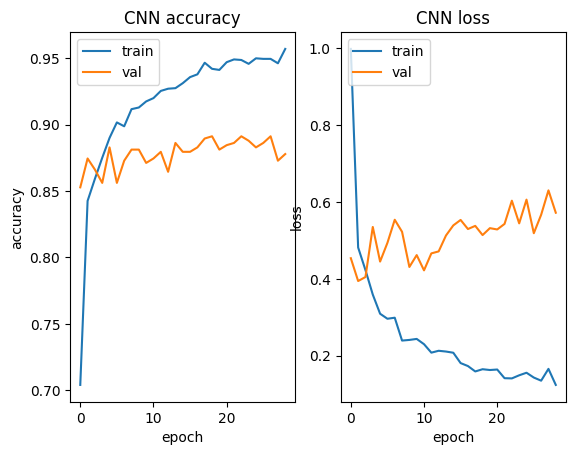

In [28]:
# Plot model history
plot_history(cnn_history, test_score, val_score)

In [29]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         2359424   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                                 
 dense_2 (Dense)             (None, 1, 1, 64)          8256      
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

# Single prediction

In [34]:
def recognize_image(path, show_image=False):
    img = load_img(path, target_size=image_size)
    if show_image==True:
        plt.figure(figsize=(3,3))
        display = plt.imshow(img)
    img = img_to_array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    result = cnn.predict(img, verbose=0)
    result = result.tolist()[0]
    pred = classes[result.index(max(result))]
    return result, pred

In [32]:
recognize_image('/content/val/buildings/20057.jpg')

([1.0,
  0.30820968747138977,
  0.001374341663904488,
  5.450649376292915e-10,
  0.9942893981933594,
  0.9999964237213135],
 'buildings')